In [1]:
import pandas as pd
import numpy as np
from glob import glob
from re import match, sub
from missingno import matrix as mmatrix
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from math import ceil
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from os import listdir
from statsmodels.formula.api import ols

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
%%html
<style>
    .jp-WindowedPanel-outer {
        padding: 0% 10% !important;
    }
    .jp-RenderedImage img {
        width: 50%;
        transform: translateX(-50%);
        margin-left: 50%;
    }
</style>


In [8]:
df = pd.read_csv('data/modelling_data.csv', parse_dates=['DATETIME'], date_format='%Y-%m-%d %H:%M:%S')

df


,DATETIME,TEMPERATURE,state,TOTALDEMAND,REGIONID,hour,month,year,day_label,is_weekday,...,h1_hour,h1_day,h1_month,h1_year,h24_ahead,h24_hour,h24_day,h24_month,h24_year,solar_exposure
0,2010-01-01 00:00:00,23.1,NSW,8038.00,NSW1,0,1,2010,Fri,True,...,1.0,5.0,1.0,2010.0,7574.85,0.0,6.0,1.0,2010.0,14.6
1,2010-01-01 00:30:00,22.9,NSW,7809.31,NSW1,0,1,2010,Fri,True,...,1.0,5.0,1.0,2010.0,7343.30,0.0,6.0,1.0,2010.0,14.6
2,2010-01-01 01:00:00,22.6,NSW,7483.69,NSW1,1,1,2010,Fri,True,...,2.0,5.0,1.0,2010.0,7099.73,1.0,6.0,1.0,2010.0,14.6
3,2010-01-01 01:30:00,22.5,NSW,7117.23,NSW1,1,1,2010,Fri,True,...,2.0,5.0,1.0,2010.0,6779.80,1.0,6.0,1.0,2010.0,14.6
4,2010-01-01 02:00:00,22.5,NSW,6812.03,NSW1,2,1,2010,Fri,True,...,3.0,5.0,1.0,2010.0,6497.47,2.0,6.0,1.0,2010.0,14.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195159,2021-03-16 22:00:00,20.4,NSW,7373.83,NSW1,22,3,2021,Tue,True,...,23.0,2.0,3.0,2021.0,7419.77,22.0,3.0,3.0,2021.0,9.1
195160,2021-03-16 22:30:00,20.5,NSW,7345.78,NSW1,22,3,2021,Tue,True,...,23.0,2.0,3.0,2021.0,7417.91,22.0,3.0,3.0,2021.0,9.1
195161,2021-03-16 23:00:00,20.3,NSW,7218.99,NSW1,23,3,2021,Tue,True,...,0.0,3.0,3.0,2021.0,7287.32,23.0,3.0,3.0,2021.0,9.1
195162,2021-03-16 23:30:00,19.7,NSW,7056.88,NSW1,23,3,2021,Tue,True,...,0.0,3.0,3.0,2021.0,7172.39,23.0,3.0,3.0,2021.0,9.1


In [67]:
# df = pd.read_csv('data/modelling_data.csv', parse_dates=['DATETIME'], date_format='%Y-%m-%d %H:%M:%S')

# y_cols = ['h1_ahead', 'h24_ahead']
drop_cols = ['state', 'REGIONID', 'day_label']
# df = df.copy()

# for i in range(1, 49):
#     shift = 30*i
#     df_shift = df.copy()[['DATETIME', 'TOTALDEMAND']].rename(columns={'TOTALDEMAND': f'TM{shift}'})
#     df_shift['DATETIME'] += timedelta(minutes=shift)
#     df = pd.merge(df, df_shift, how='left', on='DATETIME')

# df = df.set_index('DATETIME').dropna()

X_df, y_df = df.drop(columns=[*drop_cols, *y_cols]), df[y_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

X_y = [X_train, X_test, y_train, y_test] = train_test_split(
    X_scaled, y_df, test_size=0.2, shuffle=False
)
X_y = [tf.convert_to_tensor(d) for d in X_y]
[X_train, X_test, y_train, y_test] = X_y

train_val_I = TimeSeriesSplit(n_splits=10).split(X_train)

for train, val in train_val_I:
    print(train.shape, val.shape)

X_val = X_train[train.max()+1:]
y_val = y_train[train.max()+1:]
X_train = X_train[:train.max()+1]
y_train = y_train[:train.max()+1]

X_train


(13357,) (13349,)
(26706,) (13349,)
(40055,) (13349,)
(53404,) (13349,)
(66753,) (13349,)
(80102,) (13349,)
(93451,) (13349,)
(106800,) (13349,)
(120149,) (13349,)
(133498,) (13349,)


<tf.Tensor: shape=(133498, 70), dtype=float64, numpy=
array([[ 1.10104868, -0.38987805, -1.66153793, ..., -0.46159206,
        -0.20823074, -0.03029572],
       [ 1.15203642, -0.57001819, -1.66153793, ..., -0.74684097,
        -0.46170882, -0.20832724],
       [ 1.13504051, -0.7595096 , -1.51710417, ..., -0.98440569,
        -0.74697869, -0.46181722],
       ...,
       [ 0.76113045, -0.00505264,  0.64940233, ...,  0.2651754 ,
         0.11651421, -0.00937007],
       [ 0.62516315,  0.10232349,  0.64940233, ...,  0.51912523,
         0.26511205,  0.11643296],
       [ 0.50619177,  0.28889749,  0.7938361 , ...,  0.91775448,
         0.51908055,  0.26503779]])>

In [4]:
import tensorflow as tf
# from tensorflow import keras # for building Neural Networks
# from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MAPE, MeanAbsolutePercentageError, MSE
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed, LSTM # for creating layers inside the Neural Network
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from scikeras.wrappers import KerasClassifier


In [15]:
X_cols = [
    'TEMPERATURE', 'TOTALDEMAND', 'hour', 'is_weekday', 
    'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 
    'h1_hour', 'h1_day', 'h24_hour', 'h24_day'
]
y_cols = ['h1_ahead', 'h24_ahead']
X_y_df = df.dropna()[X_cols + y_cols].astype(float).dropna()
X_df = X_y_df.drop(columns=y_cols)
y_df = X_y_df[y_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

X_y = [X_train, X_test, y_train, y_test] = train_test_split(
    X_scaled, y_df, test_size=0.2, shuffle=False
)
X_y = [tf.convert_to_tensor(d) for d in X_y]
[X_train, X_test, y_train, y_test] = X_y

train_val_I = TimeSeriesSplit(n_splits=10).split(X_train)

for train, val in train_val_I:
    print(train.shape, val.shape)

X_val = X_train[train.max()+1:]
y_val = y_train[train.max()+1:]
X_train = X_train[:train.max()+1]
y_train = y_train[:train.max()+1]

X_train


(14201,) (14193,)
(28394,) (14193,)
(42587,) (14193,)
(56780,) (14193,)
(70973,) (14193,)
(85166,) (14193,)
(99359,) (14193,)
(113552,) (14193,)
(127745,) (14193,)
(141938,) (14193,)


<tf.Tensor: shape=(141938, 15), dtype=float64, numpy=
array([[ 0.94671296, -0.05587763, -1.66190824, ...,  0.9995332 ,
        -1.66190824,  1.50016561],
       [ 0.91271286, -0.23204347, -1.66190824, ...,  0.9995332 ,
        -1.66190824,  1.50016561],
       [ 0.8617127 , -0.482877  , -1.51747447, ...,  0.9995332 ,
        -1.51747447,  1.50016561],
       ...,
       [ 0.94671296,  0.73329818,  0.64903206, ...,  0.9995332 ,
         0.64903206,  1.50016561],
       [ 0.89571281,  0.74687902,  0.79346583, ...,  0.9995332 ,
         0.79346583,  1.50016561],
       [ 0.84471265,  0.6258146 ,  0.79346583, ...,  0.9995332 ,
         0.79346583,  1.50016561]])>

In [68]:
for h in [1, 24]:
        print(f'H{h}'.rjust(3) + ':', ols(
            f"\
h{h}_ahead ~ TEMPERATURE + I(TEMPERATURE**2) + I(TEMPERATURE**3) + I(TEMPERATURE**4) + is_weekday + \
             TOTALDEMAND + I(TOTALDEMAND**2) + I(TOTALDEMAND**3) + I(TOTALDEMAND**4)", X_y_df
        ).fit().rsquared)


 H1: 0.9000287252208968
H24: 0.7690442220180929


In [78]:
main_input = Input(shape=tuple(X_train[0].shape), name="input")
previous_layer = main_input
for i in range(1):
    # previous_layer = BatchNormalization()(previous_layer)
    previous_layer = Dense(32, name=f"linear_{i+1}", activation='linear')(previous_layer)
    previous_layer = Dense(32, name=f"relu_{i+1}", activation='relu')(previous_layer)
main_output = Dense(2, name=f"output")(previous_layer)

model_mlp = Model(inputs=main_input, outputs=main_output, name="MLP")

def scheduler(epoch, lr):
    return 0.0001 if epoch % 2 == 1 else 0.001

model_mlp.compile(optimizer=Adam(
    learning_rate=.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=1e-4, # Try 1e-5 next.
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name='Adam',
), loss=MeanAbsolutePercentageError(), metrics=[MSE])
mlp_history = model_mlp.fit(
    X_train, y_train, verbose=1, validation_data=(X_val, y_val), shuffle=False,
    epochs=200, batch_size=2**10, 
    callbacks=[
        LearningRateScheduler(scheduler), 
        # EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True), 
    ]
)



Epoch 1/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 99.9425 - mean_squared_error: 72840344.0000 - val_loss: 99.5105 - val_mean_squared_error: 67196496.0000 - learning_rate: 0.0010
Epoch 2/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 99.3575 - mean_squared_error: 71955120.0000 - val_loss: 99.3648 - val_mean_squared_error: 67008264.0000 - learning_rate: 1.0000e-04
Epoch 3/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 98.4965 - mean_squared_error: 70784112.0000 - val_loss: 93.3462 - val_mean_squared_error: 59653552.0000 - learning_rate: 0.0010
Epoch 4/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 92.2342 - mean_squared_error: 62018080.0000 - val_loss: 92.1743 - val_mean_squared_error: 58304812.0000 - learning_rate: 1.0000e-04
Epoch 5/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 87.7204 - mean_squared_error: 56723612.0000 - val_loss: 71.8008 - val_mean_squared_error: 38974072.0000 - learning_rate: 0.0010
Epoch 6/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms

**0.0001 if epoch % 2 == 1 else 0.001  batch_size=2\*\*10**

*epochs=1000*  

 H1 MAPE: 1.0676512  
H24 MAPE: 3.728122  7  
   
*epochs=3000*  

 H1 MAPE: 0.95467323  
H24 MAPE: 3.6277666  

*epochs=5000*  

 H1 MAPE: 0.9321479  
H24 MAPE: 3.6467154  

 


418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 H1 MAPE: 1.7282096
H24 MAPE: 4.9141417
 H1 R2: 0.9711272932377292
H24 R2: 0.7936532500966176


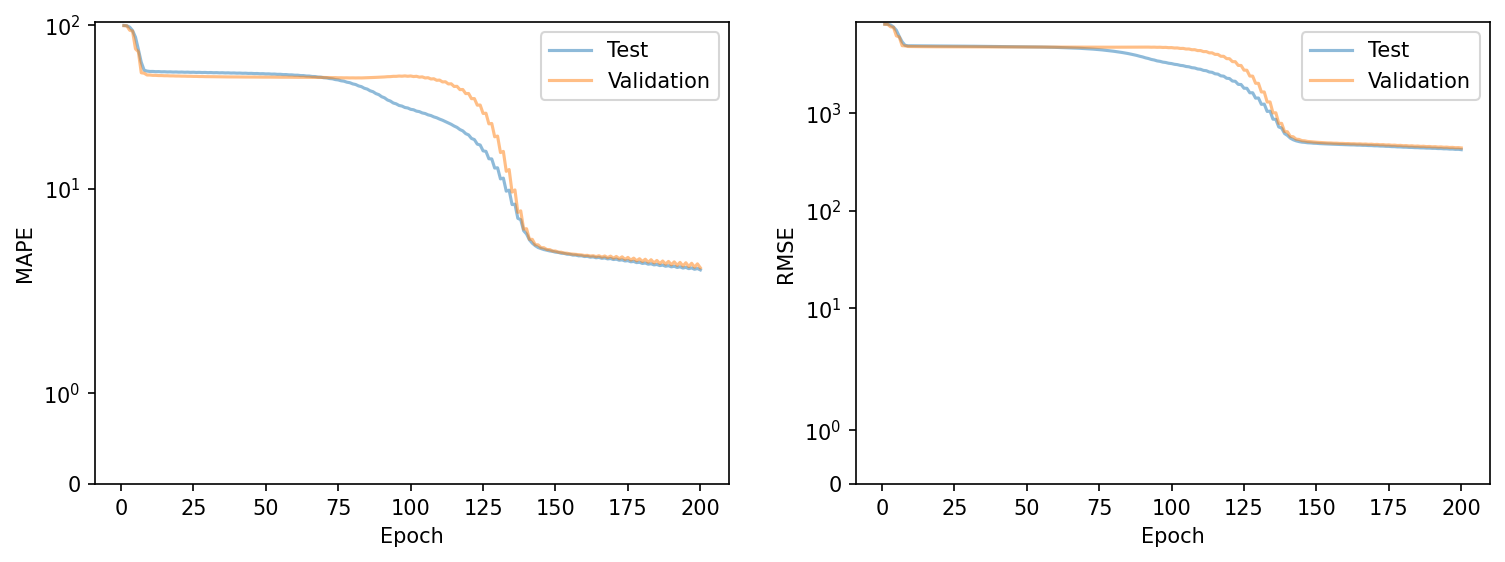

In [79]:
y_pred = model_mlp.predict(X_val)
for i in range(2):
    print(('H24' if i else 'H1'.rjust(3)) + ' MAPE:', MAPE(y_val[:,i], y_pred[:,i]).numpy())
for i in range(2):
    print(('H24' if i else 'H1'.rjust(3)) + ' R2:', r2_score(y_val[:,i], y_pred[:,i]))

mlp_history_df = pd.DataFrame(mlp_history.history)
mlp_history_df['epoch'] = (mlp_history_df.index+1).to_list()
mse_cols = [e for e in mlp_history_df.columns if 'mean_squared_error' in e]
mlp_history_df[[e.replace('mean_squared_error', 'RMSE') for e in mse_cols]] = mlp_history_df[mse_cols].apply(lambda d: d.apply(lambda e: e**.5), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12,4), dpi=150)
metrics = ['loss', 'RMSE']

for i, ax in enumerate(axes):

    metric = metrics[i]
    label = metric.replace('loss', 'MAPE')

    sns.lineplot(mlp_history_df, x='epoch', y=metric, ax=ax, label='Test', alpha=0.5)
    sns.lineplot(mlp_history_df, x='epoch', y=f"val_{metric}", ax=ax, label='Validation', alpha=0.5)

    ax.set_ylim(0)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    ax.set_yscale('symlog')
    
plt.show()
    


200 runs  
  
 H1 MAPE: 1.7282096  
H24 MAPE: 4.9141417  


  
 H1: 1.3631097  
H24: 6.5616884  
  




In [248]:
main_input = Input(shape=(X_train[0].shape[0],1), name="input")
previous_layer = main_input
previous_layer = Bidirectional(LSTM(64, return_sequences=True), name=f"BD_1")(previous_layer)
previous_layer = Bidirectional(LSTM(32), name=f"BD_2")(previous_layer)

previous_layer = Dense(32, name=f"relu_{1}", activation='relu')(previous_layer)
main_output = Dense(2, name=f"output")(previous_layer)

def scheduler(epoch, lr):
    return 0.001 if epoch % 2 == 1 else 0.01

model_lstm = Model(inputs=main_input, outputs=main_output, name="BD-LSTM")
model_lstm.compile(optimizer=Adam(
    learning_rate=.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name='Adam',
), loss=MeanAbsolutePercentageError(), metrics=[MSE])
lstm_history = model_lstm.fit(
    X_train, y_train, verbose=1, validation_data=(X_val, y_val), shuffle=False,
    epochs=1000, batch_size=2**5, 
    callbacks=[
        LearningRateScheduler(scheduler), 
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True), 
    ]
)

# LSTM(Hidden, activation='relu')
# batch_size=64, verbose=0, shuffle=False


Epoch 1/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 20.7106 - mean_squared_error: 10166402.0000 - val_loss: 5.2928 - val_mean_squared_error: 391766.9375 - learning_rate: 0.0100
Epoch 2/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 4.2838 - mean_squared_error: 302565.7500 - val_loss: 3.9626 - val_mean_squared_error: 199187.7969 - learning_rate: 0.0010
Epoch 3/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 4.3101 - mean_squared_error: 274474.0000 - val_loss: 4.4120 - val_mean_squared_error: 253933.4844 - learning_rate: 0.0100
Epoch 4/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 4.0149 - mean_squared_error: 255520.8281 - val_loss: 3.8214 - val_mean_squared_error: 184829.7344 - learning_rate: 0.0010
Epoch 5/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 4.0606 - mean_squared_error: 253127.0938 - val_loss: 4.2436 - val_mean_squared_error: 235522.3906 - learning_rate: 0.0100
Epoch 6/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - los

KeyboardInterrupt: 

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  LR=0.01  
 H1: 1.8942682  
H24: 3.261359  
  
 H1: 2.3578866  
H24: 3.7653885  

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  LR=0.001  
 H1: 2.2099416  
H24: 3.548185  

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  0.0001 if epoch % 2 == 1 else 0.001  (Epoch 154/1000)  
 H1: 1.4781239  
H24: 3.2230973  


In [51]:
y_pred = model_lstm.predict(X_val)
for i in range(2):
    print(('H24' if i else 'H1'.rjust(3)) + ':', MAPE(y_val[:,i], y_pred[:,i]).numpy())

lstm_history_df = pd.DataFrame(lstm_history.history)
lstm_history_df['epoch'] = (lstm_history_df.index+1).to_list()
mse_cols = [e for e in lstm_history_df.columns if 'mean_squared_error' in e]
lstm_history_df[[e.replace('mean_squared_error', 'RMSE') for e in mse_cols]] = lstm_history_df[mse_cols].apply(lambda d: d.apply(lambda e: e**.5), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
metrics = ['loss', 'RMSE']

for i, ax in enumerate(axes):

    metric = metrics[i]
    label = metric.replace('loss', 'MAPE')

    sns.lineplot(lstm_history_df, x='epoch', y=metric, ax=ax, label='Test')
    sns.lineplot(lstm_history_df, x='epoch', y=f"val_{metric}", ax=ax, label='Validation')

    ax.set_ylim(0)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    
plt.show()


NameError: name 'model_lstm' is not defined